<a href="https://colab.research.google.com/github/mehkzhra/Gender-Detection/blob/main/Gender_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle opencv-python ipywidgets


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 86% 286M/331M [00:02<00:00, 84.7MB/s]
100% 331M/331M [00:02<00:00, 133MB/s] 


In [ ]:
!ls -lh utkface-new.zip


-rw-r--r-- 1 root root 332M Oct  3  2019 utkface-new.zip


In [ ]:
import zipfile, os

zip_path = "/content/utkface-new.zip"
extract_folder = "/content/utkface/"
os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("Extracted! Total images:", len(os.listdir(extract_folder)))


Extracted! Total images: 3


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os


In [ ]:
class UTKFaceDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.folder_path, img_name)

        # filename format: age_gender_race_date.jpg
        gender = int(img_name.split("_")[1])  # 0 or 1

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, gender


In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset_path = "/content/utkface/UTKFace"

dataset = UTKFaceDataset(dataset_path, transform)

print("Total images:", len(dataset))


Total images: 23708


In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Train samples: 18966
Test samples: 4742


In [ ]:
class GenderCNN(nn.Module):
    def __init__(self):
        super(GenderCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

model = GenderCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


GenderCNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/5, Loss: 142.7160
Epoch 2/5, Loss: 97.6536
Epoch 3/5, Loss: 84.9234
Epoch 4/5, Loss: 76.3708
Epoch 5/5, Loss: 70.5584


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy:", 100 * correct / total, "%")


Accuracy: 89.62463095740193 %


In [ ]:
torch.save(model.state_dict(), "gender_cnn.pth")
print("Model Saved!")


Model Saved!


In [ ]:
!wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml


--2025-12-08 08:44:05--  https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml [following]
--2025-12-08 08:44:06--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2025

In [ ]:
import cv2
import numpy as np
from PIL import Image

face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

def detect_and_crop_face(img):
    # convert PIL → OpenCV (RGB → BGR)
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    faces = face_cascade.detectMultiScale(
        img_cv, scaleFactor=1.2, minNeighbors=5, minSize=(80, 80)
    )

    if len(faces) == 0:
        print("No face detected!")
        return img  # fallback

    # take the biggest face
    x, y, w, h = max(faces, key=lambda f: f[2] * f[3])
    cropped = img_cv[y:y+h, x:x+w]

    # convert back to PIL
    cropped = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    return cropped


In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# Same model architecture you trained
class GenderCNN(nn.Module):
    def __init__(self):
        super(GenderCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = GenderCNN().to(device)
model.load_state_dict(torch.load("gender_cnn.pth", map_location=device))
model.eval()

# Transform used in training
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

print("Model loaded!")


Model loaded!


In [ ]:
from google.colab import output
import cv2
import numpy as np
from PIL import Image
from google.colab.output import eval_js
from base64 import b64decode
from io import BytesIO   # ← ADD THIS


def capture_image():
    js = """
        async function takePhoto() {
          const video = document.createElement('video');
          const stream = await navigator.mediaDevices.getUserMedia({ video: true });

          document.body.appendChild(video);
          video.srcObject = stream;
          await video.play();

          await new Promise(resolve => setTimeout(resolve, 2000));

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          const ctx = canvas.getContext('2d');
          ctx.drawImage(video, 0, 0);
          stream.getTracks().forEach(t => t.stop());
          video.remove();

          return canvas.toDataURL();
        }
        takePhoto();
    """
    data = eval_js(js)
    data = data.split(',')[1]
    img = Image.open(BytesIO(b64decode(data)))
    return img


Prediction: Female


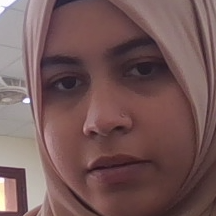

In [ ]:
img = capture_image()

# Convert RGBA → RGB
if img.mode == "RGBA":
    img = img.convert("RGB")

# FACE CROP HERE
img = detect_and_crop_face(img)

# transform to tensor
img_tensor = transform(img).unsqueeze(0).to(device)

# prediction
with torch.no_grad():
    output = model(img_tensor)
    _, pred = torch.max(output, 1)

gender = "Male" if pred.item() == 0 else "Female"
print("Prediction:", gender)

img
